In [1]:
from emulator_utils.pre_process import log_standard, minmax, standard_minmax, unscale, save_scaler
from emulator_utils.read_data import readpowerspec
from emulator_utils.split import random_holdout
from emulator_utils.surrogates import simple_mlp, train_mlp, save_mlp, load_mlp, mcdrop_pred

In [2]:
import matplotlib.pylab as plt
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [3]:
mode='test'

In [4]:
# dirIn = '../test/data/sps_ugrizy/'
dirIn = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/'

# mags = np.load(dirIn + 'colors.npy')
mags = np.load(dirIn + 'spec.npy')

ebv = np.load(dirIn + 'ebv.npy')
redshift = np.load(dirIn + 'redshift.npy')
sfh = np.load(dirIn + 'sfh.npy')
wave = np.load(dirIn + 'wave_spec.npy')

In [5]:
sps_inputs = np.concatenate((redshift[np.newaxis, :], ebv[np.newaxis, :], sfh.T), axis=0).T

In [6]:
redshift.min(), redshift.max(), ebv.min(), ebv.max()

(2.7489090568105492e-05,
 1.9995817070315638,
 0.0003275080205966674,
 4.999372366186118)

In [7]:
scaled, scaler = standard_minmax(sps_inputs)
save_scaler(scaler, '../test/model/input_scale')

Saved the pre-processing pipeline at: ../test/model/input_scale.pkl


In [8]:
scaled_y, scaler_y = log_standard(mags)
save_scaler(scaler_y, '../test/model/output_scale')

Saved the pre-processing pipeline at: ../test/model/output_scale.pkl


In [9]:
param_train, param_test, mag_train, mag_test = random_holdout(scaled, scaled_y, split_fraction = 0.1)

In [10]:
param_train.shape, mag_train.shape

((9000, 180), (9000, 1212))

In [11]:
mlp = simple_mlp(input_shape=param_train.shape[1], 
                 output_shape=mag_train.shape[1], 
                 hidden_dims=[512, 512, 1024, 1024, 2048, 2048, 1024, 1024])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               92672     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1

### Setting Hyper-parameters

In [12]:
learning_rate = 5e-3
decay_rate = 0.01
batch_size = 256
num_epochs = 300

In [13]:
if (mode=='train'):
    mlp, train_history = train_mlp(mlp, 
                        # param_train, pk_train, param_test, pk_test, 
                        param_train, mag_train, param_test, mag_test,
                        learning_rate, decay_rate, num_epochs, batch_size);

    save_mlp(mlp, '../test/model/spec_mlp')


In [14]:
if (mode=='train'):
    plt.figure(2111)
    plt.plot(train_history.history['loss'], label = 'loss')
    plt.plot(train_history.history['val_loss'], label = 'val loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


In [15]:
mlp = load_mlp('../test/model/spec_mlp')

Model loaded from: ../test/model/spec_mlp


In [16]:
def prob_color(param_in):
    
    '''
    This provides p(colors|redshift, dust). But SFH is chosen (arbitrarily). 
    
    '''
    
    redshift_in = param_in[:, 0]
    ebv_in = param_in[:, 1]
    
    
    sfh_id = 153
    sfh_in = sfh[sfh_id][np.newaxis, :]
    sfh_in = np.tile(sfh_in, (ebv_in.shape[0], 1))

    input_params = np.concatenate( (redshift_in.reshape(-1, 1), 
                                    ebv_in.reshape(-1, 1), 
                                    sfh_in) , axis=1)

    # sps_in = scaler.transform(input_params)
  
    #############  
    
    mags_pred, _, _ = mcdrop_pred(input_params, mlp, scaler, scaler_y)
    # param_test_unscaled, mlp, scaler, scaler_y
    return mags_pred

In [17]:
param_test_unscaled = unscale(param_test, scaler)
mlp_pred = mlp.predict(param_test_unscaled)  
color_pred = unscale(mlp_pred, scaler_y)

overflow encountered in power


In [18]:
param_train_unscaled = unscale(param_train, scaler)
param_test_unscaled = unscale(param_test, scaler)

# pcolor = prob_color(param_test_unscaled) ## wrong SFH
# mean_color = mag_forward(param_test_unscaled) ## wrong SFH

# pcolor_all = prob_color_all(param_test_unscaled)
pcolor_all, _, _ = mcdrop_pred(param_test_unscaled, mlp, scaler, scaler_y)

(1.0, 100000000.0)

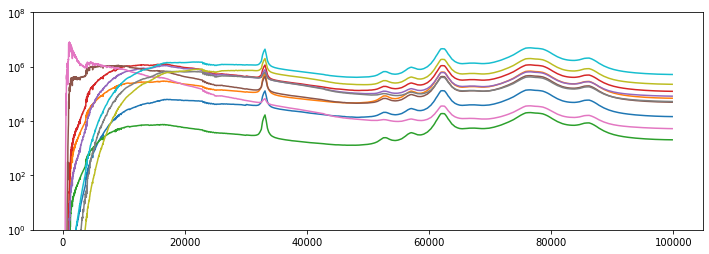

In [19]:
plt.figure(figsize = (12, 4))
plt.plot(wave, unscale(mag_test, scaler_y)[0:10].T, label='truth');
plt.yscale('log')
plt.ylim(1e0, 1e8)

(1.0, 200000000.0)

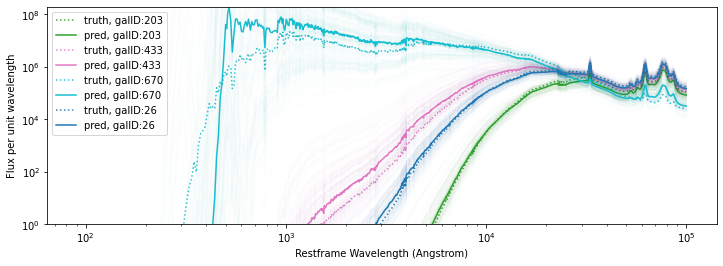

In [20]:
plt.figure(figsize = (12, 4))
# color_arr = ['blue', 'red', 'green']
# indx = -1

galID_arr =  [203, 433, 670, 26]
colorparams = galID_arr
colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))




for galID in galID_arr:

    color = colormap(normalize(galID))
    
    plt.plot(wave, unscale(mag_test, scaler_y)[galID], linestyle='dotted', color = color, label='truth, galID:%d'%galID, alpha=0.9)
    
    plt.plot(wave, pcolor_all[:, galID, :].T,  color = color, alpha=0.01)
    plt.plot(wave, np.median(pcolor_all[:, galID, :].T, axis=1),  color = color, alpha=1, label='pred, galID:%d'%galID);


plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(1e0, 2e8)
# plt.xlim(50, 1700)

(1000.0, 100000000.0)

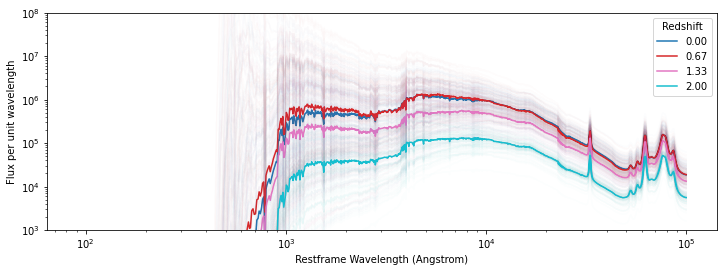

In [21]:
#### redshift variation

plt.figure(figsize = (12, 4))

dust_in = 0.4
redshift_in_array = np.linspace(1e-3, 2.0, 4)

colorparams = redshift_in_array
colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


# indx = -1
for redshift_in in redshift_in_array:
    # indx+=1
    color = colormap(normalize(redshift_in))

    pcolor = prob_color( np.array([redshift_in, dust_in])[np.newaxis, :]) ## wrong SFH
    plt.plot(wave, np.median(pcolor[:, 0, :].T, axis=1),  color = color, alpha=1.0, label='%.2f'%redshift_in);
    plt.plot(wave, pcolor[:, 0, :].T,  color = color, alpha=0.01);

    
plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.xscale('log')
plt.yscale('log')
plt.legend(title='Redshift')
plt.ylim(1e3, 1e8)

(1e-06, 1000000000000.0)

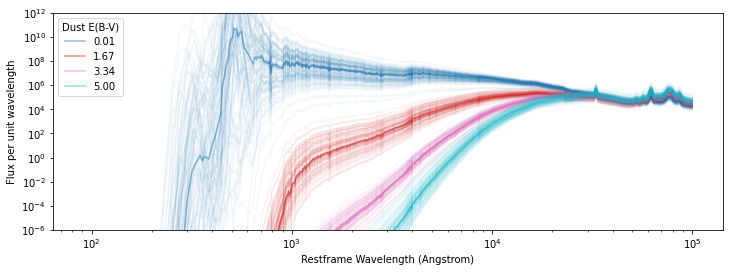

In [23]:
#### dust variation
# color_arr = ['k', 'red', 'blue', 'violet', 'k', 'orange']

plt.figure(figsize = (12, 4))

dust_in_array = np.linspace(0.01, 5.0, 4)
redshift_in = 0.4

colorparams = dust_in_array
colormap = cm.tab10
normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


indx = 0
for dust_in in dust_in_array:
    # indx+=1
    color = colormap(normalize(dust_in))

    pcolor = prob_color( np.array([redshift_in, dust_in])[np.newaxis, :]) ## wrong SFH
    plt.plot(wave, np.median(pcolor[:, 0, :].T, axis=1),  color = color, alpha=0.5, label='%.2f'%dust_in);
    plt.plot(wave, pcolor[:, 0, :].T,  color = color, alpha=0.05);
    
plt.ylabel('Flux per unit wavelength')
plt.xlabel(' Restframe Wavelength (Angstrom) ')

plt.yscale('log')
plt.xscale('log')
plt.legend(title='Dust E(B-V)')
plt.ylim(1e-6, 1e12)